## Imports

In [14]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras.models import Model
import boto3
from time import time
import os
import io
from tqdm import tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
import math
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod

## Classes to handle dataset images

In [15]:
class DatasetHandler(ABC):
    def __init__(self,
                obstacle_dataset,
                no_obstacle_dataset,
                img_width=200,
                img_height=200,
                batch_size=32,
                rand_images=True,
                num_rand_images=10):
        
        self.obstacle_dataset = obstacle_dataset
        self.no_obstacle_dataset = no_obstacle_dataset
        self.dataset = '/'.join(self.obstacle_dataset.split('/')[:-1])
        self.img_width = img_width
        self.img_height = img_height
        self.obstacle_images = []
        self.no_obstacle_images = []
        self._update_image_lists = True
        
        if rand_images:
            self.batch_size = min(batch_size, num_rand_images*2)
        else:
            self.batch_size = batch_size
            
        if rand_images:
            self.num_rand_images = num_rand_images
            self.num_obstacles = num_rand_images
            self.num_no_obstacles = num_rand_images
            self.num_images = num_rand_images*2
        else:
            # Will be determined while reading all images from dataset
            self.num_obstacles = 0
            self.num_no_obstacles = 0
            self.num_images = 0
            
        if rand_images:
            self.obstacle_image_names = self._get_random_dataset_image_names(self.obstacle_dataset)
            self.no_obstacle_image_names = self._get_random_dataset_image_names(self.no_obstacle_dataset)
        else:
            (self.obstacle_image_names,
            self.num_obstacles) = self._get_all_dataset_image_names(self.obstacle_dataset)
            (self.no_obstacle_image_names,
            self.num_no_obstacles) = self._get_all_dataset_image_names(self.no_obstacle_dataset)
            
    @abstractmethod
    def _get_random_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_all_dataset_image_names(self, dataset):
        pass
    
    @abstractmethod
    def _get_image(self, imname):
        pass
    
    @abstractmethod
    def _preprocess_image(self, im):
        pass
    
    @abstractmethod
    def image_generator(self):
        pass

In [16]:
class CloudDatasetHandler(DatasetHandler):
    
    def _get_random_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])

        image_names = np.array(image_names)
        np.random.shuffle(image_names)
        image_names = image_names[:self.num_rand_images]

        return list(image_names)

    def _get_all_dataset_image_names(self, dataset):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        image_names = []
        num_images = 0

        paginator = client.get_paginator('list_objects')
        page_iterator = paginator.paginate(Bucket=bucket, Prefix=dataset)

        for page in page_iterator:
            for image_name in page['Contents']:
                if image_name['Key'].split('.')[-1] == 'jpg':
                    image_names.append(image_name['Key'])
                    num_images += 1

        return image_names, num_images
            
    def _get_image(self, imname):
        client = boto3.client('s3')
        bucket = 'obstacles-classification'
        key = imname
        outfile = io.BytesIO()
        client.download_fileobj(bucket, key, outfile)
        outfile.seek(0)
        im = plt.imread(outfile, format='jpg')
        return im

    def _preprocess_image(self, im):
        w = im.shape[1]
        im1 = im[:,:w//2]
        im2 = im[:,w//2:]
        sub = cv2.subtract(im1, im2)
        sub = sub.reshape(sub.shape[0], sub.shape[1], 1)
        arr = keras.preprocessing.image.smart_resize(sub,
                                                     (self.img_height, self.img_width),
                                                     interpolation='bilinear')
        arr /= 255.0
        return arr
    
    def image_generator(self):
        s3 = boto3.resource('s3')
        inputs = []
        outputs = [1]*self.num_obstacles + [0]*self.num_no_obstacles

        for image_name in tqdm(self.obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)

        for image_name in tqdm(self.no_obstacle_image_names):
            im = self._get_image(image_name)
            if self._update_image_lists:
                self.no_obstacle_images.append(im)
            im = self._preprocess_image(im)
            inputs.append(im)
            
        self._update_image_lists = False

        for i in range(0, self.num_images, self.batch_size):
            x = np.array(inputs[i:i+self.batch_size])
            y = np.array(outputs[i:i+self.batch_size])
            yield(x, y)

In [17]:
class LocalDatasetHandler(DatasetHandler):
    
    def _get_random_dataset_image_names(self, dataset):
        pass

    def _get_all_dataset_image_names(self, dataset):
        pass

    def image_generator(self):
        pass
            
    def _get_image(self, imname):
        pass

    def _preprocess_image(im):
        pass

## Function to display Confusion Matrix

In [18]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Obstacles Detected (True Negatives): ', cm[0][0])
  print('No Obstacles Incorrectly Detected (False Positives): ', cm[0][1])
  print('Obstacles Missed (False Negatives): ', cm[1][0])
  print('Obstacles Detected (True Positives): ', cm[1][1])
  print('Total Obstacles: ', np.sum(cm[1]))

## Main

In [19]:
# Set these variables per actual environment
model_path = '/home/drevital/cs_video_processor/models/suzuyo'
cloud_dataset = True
obstacle_dataset = 'suzuyo/eval_pairs/obstacle'
no_obstacle_dataset = 'suzuyo/eval_pairs/no_obstacle'
rand_images = True
num_rand_images = 100

#
model = tf.keras.models.load_model(model_path)
dataset_handlers = [LocalDatasetHandler, CloudDatasetHandler]
handler = dataset_handlers[cloud_dataset](obstacle_dataset,
                                         no_obstacle_dataset,
                                         rand_images=rand_images,
                                         num_rand_images=num_rand_images)

## Evaluate Model

In [20]:
#image_generator = handler.get_image_generator()
metrics = model.evaluate_generator(handler.image_generator(), verbose=1)

for name, value in zip(model.metrics_names, metrics):
  print(name, ': ', value)
print()

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


7/7 [==============================] - 12s 2s/step - loss: 0.4014 - auc: 0.9779 - recall: 0.8500 - specifity: 0.9900
loss :  0.40142959356307983
auc :  0.9779499769210815
recall :  0.8500000238418579
specifity :  0.9900000095367432



## Predict with the model and print prediction charts

100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


7/7 [==============================] - 1s 98ms/step
No Obstacles Detected (True Negatives):  99
No Obstacles Incorrectly Detected (False Positives):  1
Obstacles Missed (False Negatives):  15
Obstacles Detected (True Positives):  85
Total Obstacles:  100


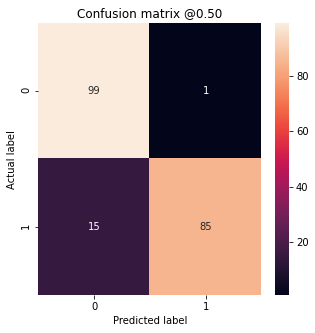

In [21]:
labels = np.array([1]*(handler.num_obstacles) + [0]*(handler.num_no_obstacles))
num_prediction_batches = math.ceil(handler.num_images/handler.batch_size)

predictions = model.predict_generator(handler.image_generator(),
                                      num_prediction_batches,
                                      verbose=1)

plot_cm(labels, predictions) # Default: threshold = 0.5

## Display False Negatives

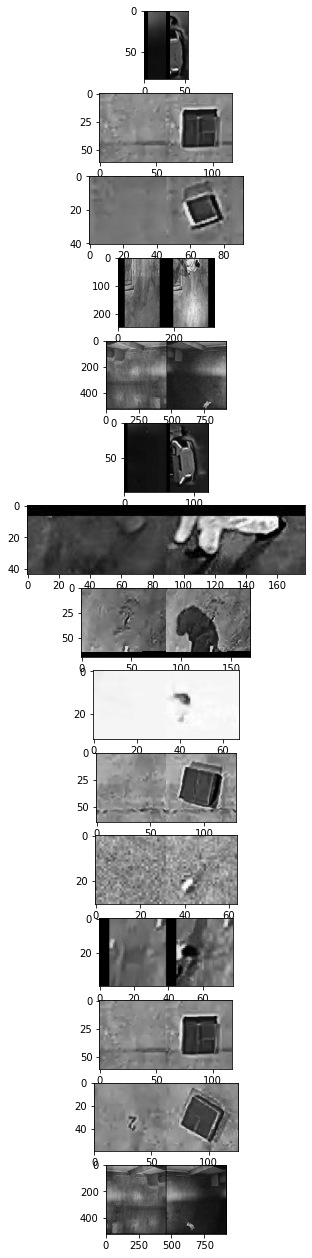

In [22]:
false_negatives = [im for i, im in enumerate(handler.obstacle_images) if predictions[i] <= 0.5]

if len(false_negatives) > 1:
    num_images = len(false_negatives)
    _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

    for i, im in enumerate(false_negatives):
        axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
elif false_negatives:
    plt.imshow(false_negatives[0], cmap='gray', vmin=0, vmax=255)
    plt.show()     

## Display False Positives

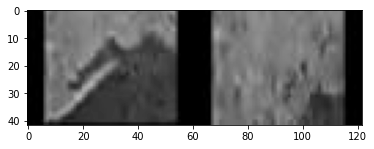

In [23]:
false_positives = [im for i, im in enumerate(handler.no_obstacle_images) if predictions[i+handler.num_obstacles] > 0.5]

if len(false_positives) > 1:
    num_images = len(false_positives)
    _, axarr = plt.subplots(num_images, 1, figsize=(1.5*num_images, 1.5*num_images))

    for i, im in enumerate(false_positives):
        axarr[i].imshow(im, cmap='gray', vmin=0, vmax=255)
elif false_positives:
    plt.imshow(false_positives[0], cmap='gray', vmin=0, vmax=255)
    plt.show()    

## Find Optimal Threshold

In [24]:
true_values = [1]*handler.num_obstacles + [0]*handler.num_no_obstacles
fpr, tpr, thresholds = roc_curve(true_values, predictions)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
optimal_threshold = thresholds[ix]
print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.26537632942199707


## Use Optimal Threshold

No Obstacles Detected (True Negatives):  96
No Obstacles Incorrectly Detected (False Positives):  4
Obstacles Missed (False Negatives):  6
Obstacles Detected (True Positives):  94
Total Obstacles:  100


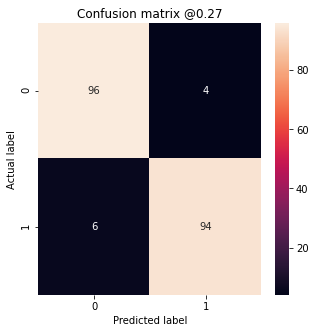

In [25]:
plot_cm(labels, predictions, p=optimal_threshold) 